# <a id='toc1_'></a>[Image Captioning Preprocessing](#toc0_)

Ananya Chattoraj

cananya53@gmail.com

**Table of contents**<a id='toc0_'></a>    
- [Image Captioning Preprocessing](#toc1_)    
  - [Introduction](#toc1_1_)    
  - [Notes](#toc1_2_)    
  - [Preprocessing for Models 1 - 8](#toc1_3_)    
    - [A brief interlude back to EDA](#toc1_3_1_)    
  - [Tokenization and training split for Models 1 - 12](#toc1_4_)    
  - [Image Features for Models 9 - 17](#toc1_5_)    
  - [Processing all 5 captions for Models 13 - 17](#toc1_6_)    
  - [Moving Forward](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

This notebook continues the data wrangling and preprocessing from the previous notebook titled EDA. In this notebook, my aim is to preprocess both images and texts for model training. Recall that the dataset used is the Flickr8k Images + Captions set from Kaggle.

## <a id='toc1_2_'></a>[Notes](#toc0_)

This entire project proceeded iteratively. As such, decisions were made post-initial modeling to come back and change preprocessing techniques. This notebook will roughly follow the order of my modeling iterations. To navigate directly to the most updated version of the preprocessing, please use the table of contents and visit the notebook named "final".

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetV2S
from keras.utils import load_img, img_to_array, to_categorical, pad_sequences, image_dataset_from_directory, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Conv2D, LSTM, Embedding, Add, Input
from sklearn.model_selection import train_test_split
from os import listdir
import os
import shutil
import re
import nltk
from nltk.corpus import stopwords
from PIL import Image
from pickle import dump

In [2]:
imagefolder = 'flickr8k/images/'
imagesize = 224
traindirectory = 'flickr8k/images/train'
testdirectory = 'flickr8k/images/test'
valdirectory = 'flickr8k/images/val'

In [3]:
df1 = pd.read_pickle('caption1.pkl')
df1.head()

caption_order,image,1
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


## <a id='toc1_3_'></a>[Preprocessing for Models 1 - 8](#toc0_)

Preprocessing for models 1 - 8 involved taking only the first caption and tokenizing them. Image preprocessing was done in the modeling notebook simply by converting images into arrays (models 1 - 4) or by reshaping them and passing them directly through the basemodel (models 5 - 8).

Note that in preprocessing for models 9 - 12, tokenization was performed on the whole caption set to account for the fact that if the model didn't learn of a word's existence at all, it wouldn't be able to generate a caption using this word. My reasoning was to provide the model with a large vocabulary size given my already sampled dataset. In the final models, all 5 captions were used for increased vocabulary and tokenization was done only on the train set of caption (this will be expanded uon in the next preprocessing sections).

In [4]:
df1.rename(columns={1:'caption1'},inplace=True)
df1.head()

caption_order,image,caption1
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


I will sample my entire dataset down to just 20% of the original since my computer is now quite a few years old.

In [5]:
#Sample the dataset because potato computer
df1_sample, _, _, _ = train_test_split(df1, df1, train_size=0.2, random_state=2)

In [6]:
df1_sample.shape

(1618, 2)

In [7]:
#Captions need to be made into all lower case with special characters removed
#Captions will be stripped of extra spaces
#Captions are sequenced, so a start and an end marker are needed
df1_sample['caption1'] = df1_sample['caption1'].apply(lambda text: text.lower())
df1_sample['caption1'] = df1_sample['caption1'].apply(lambda text: re.sub(r'[^\w\s]', '', text))
df1_sample['caption1'] = df1_sample['caption1'].apply(lambda text: text.strip())
df1_sample['caption1'] = 'start ' + df1_sample['caption1'] + ' end'

In [8]:
df1_sample['caption1']

6687    start a blond girl and brunette brown hanging ...
6793    start a bmx rider in a red and black outfit is...
7916      start a dog is jumping to play in the water end
3742    start a group of greyhound dogs racing with mu...
2122    start a dog with a frisbee in front of a brown...
                              ...                        
3606    start a boy jumps through the air onto somethi...
5704       start a man rides a ski lift up a mountain end
6637    start a man has his hands up while standing ne...
2575    start a float representing the times of hangin...
7336    start a brown dog leaps up to catch an orange ...
Name: caption1, Length: 1618, dtype: object

In [9]:
df1_sample.to_pickle('df1_sample.pkl')

For my model, I will keep all stop words in captions. This is because the model is meant to ultimately generate a caption for an input image, and generated captions, like any sentence, don't make sense without stop words. To include them in generation, I will include them in training.

However, to assess the frequency of meaningful words, I will create a stopword-free tokenized list.

In [9]:
#stop word removal option for tokenization
stops = set(stopwords.words('english'))
print(stops)

{'be', 'for', 'my', 'your', 'above', 'do', "you'll", 'a', 'having', 'themselves', 'over', 'both', 'whom', "doesn't", 'hasn', 'was', 'few', 'any', 'herself', 'during', 'are', 'theirs', 'now', "couldn't", 'just', 'were', "that'll", 'same', "shan't", 'doing', 'before', 'd', 'how', "should've", 'did', 'himself', 'we', "it's", 'that', 'been', 'between', 'by', 'doesn', 'down', 'than', 'can', 'from', 'as', 'after', 'is', 'under', "you're", 'other', 'of', 'her', 'his', 'most', "you've", 'won', 'because', 'so', "don't", 'll', 'their', 'about', 'up', 'this', "hasn't", 'in', 'and', 'yourself', 'out', 'aren', 'off', 'ourselves', 'not', 'if', 'm', 'these', "haven't", 'here', 'then', 'didn', 'am', 'have', 'being', 'each', "weren't", 'does', 'such', 've', 'while', 'what', 'our', 'some', 'no', 'myself', 'yourselves', 'shan', 't', 'an', 'on', 'only', 'ain', 'she', 'at', 'through', 'ours', 'yours', 'i', 'isn', 'with', 'again', 'which', 'o', 'needn', 'into', 'its', 'y', 'him', 'until', 'wasn', "she's", '

In [10]:
#stop word removal option for tokenization
def remove_stop_words(sentence):
    words = nltk.word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stops]
    return ' '.join(filtered_words)

In [11]:
#Create new caption column with no stop words
df1_sample['captions_no_stopwords'] = df1_sample['caption1'].apply(remove_stop_words)

In [12]:
df1_sample.head()

caption_order,image,caption1,captions_no_stopwords
6687,3644142276_caed26029e.jpg,start a blond girl and brunette brown hanging ...,start blond girl brunette brown hanging gymnas...
6793,3670907052_c827593564.jpg,start a bmx rider in a red and black outfit is...,start bmx rider red black outfit jumping motor...
7916,774009278_8e75b7d498.jpg,start a dog is jumping to play in the water end,start dog jumping play water end
3742,3027399066_ca85495775.jpg,start a group of greyhound dogs racing with mu...,start group greyhound dogs racing muzzles cove...
2122,2511019188_ca71775f2d.jpg,start a dog with a frisbee in front of a brown...,start dog frisbee front brown dog end


In [13]:
tokenizernostop = Tokenizer()
tokenizernostop.fit_on_texts(df1_sample['captions_no_stopwords'])
df1_sample['tokenized_nostops'] = tokenizernostop.texts_to_sequences(df1_sample['captions_no_stopwords'])

In [14]:
df1_sample.head()

caption_order,image,caption1,captions_no_stopwords,tokenized_nostops
6687,3644142276_caed26029e.jpg,start a blond girl and brunette brown hanging ...,start blond girl brunette brown hanging gymnas...,"[2, 144, 7, 834, 9, 248, 835, 348, 1]"
6793,3670907052_c827593564.jpg,start a bmx rider in a red and black outfit is...,start bmx rider red black outfit jumping motor...,"[2, 426, 162, 14, 5, 209, 26, 151, 1]"
7916,774009278_8e75b7d498.jpg,start a dog is jumping to play in the water end,start dog jumping play water end,"[2, 3, 26, 77, 10, 1]"
3742,3027399066_ca85495775.jpg,start a group of greyhound dogs racing with mu...,start group greyhound dogs racing muzzles cove...,"[2, 12, 210, 27, 163, 565, 566, 567, 1]"
2122,2511019188_ca71775f2d.jpg,start a dog with a frisbee in front of a brown...,start dog frisbee front brown dog end,"[2, 3, 126, 30, 9, 3, 1]"


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df1_sample['caption1'])
df1_sample['tokenized'] = tokenizer.texts_to_sequences(df1_sample['caption1'])

In [16]:
df1_sample.head()

caption_order,image,caption1,captions_no_stopwords,tokenized_nostops,tokenized
6687,3644142276_caed26029e.jpg,start a blond girl and brunette brown hanging ...,start blond girl brunette brown hanging gymnas...,"[2, 144, 7, 834, 9, 248, 835, 348, 1]","[3, 1, 181, 15, 7, 901, 17, 296, 48, 902, 400, 2]"
6793,3670907052_c827593564.jpg,start a bmx rider in a red and black outfit is...,start bmx rider red black outfit jumping motor...,"[2, 426, 162, 14, 5, 209, 26, 151, 1]","[3, 1, 484, 202, 4, 1, 28, 7, 13, 254, 8, 41, ..."
7916,774009278_8e75b7d498.jpg,start a dog is jumping to play in the water end,start dog jumping play water end,"[2, 3, 26, 77, 10, 1]","[3, 1, 9, 8, 41, 20, 105, 4, 5, 22, 2]"
3742,3027399066_ca85495775.jpg,start a group of greyhound dogs racing with mu...,start group greyhound dogs racing muzzles cove...,"[2, 12, 210, 27, 163, 565, 566, 567, 1]","[3, 1, 26, 10, 255, 42, 203, 12, 626, 627, 93,..."
2122,2511019188_ca71775f2d.jpg,start a dog with a frisbee in front of a brown...,start dog frisbee front brown dog end,"[2, 3, 126, 30, 9, 3, 1]","[3, 1, 9, 12, 1, 161, 4, 47, 10, 1, 17, 9, 2]"


In [17]:
df1_sample.to_pickle('modelingnostops.pkl')

In [18]:
# Max length of a caption will be needed when the sequences are created
max_length = max(len(d.split()) for d in df1_sample['caption1'])
max_length

33

In [19]:
# Vocab size will be needed for modeling. This one includes stop words
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size:  {vocab_size}')

Vocabulary Size:  1982


In [20]:
tokenizernostop.word_index

{'end': 1,
 'start': 2,
 'dog': 3,
 'man': 4,
 'black': 5,
 'boy': 6,
 'girl': 7,
 'white': 8,
 'brown': 9,
 'water': 10,
 'woman': 11,
 'group': 12,
 'two': 13,
 'red': 14,
 'people': 15,
 'blue': 16,
 'shirt': 17,
 'ball': 18,
 'playing': 19,
 'wearing': 20,
 'standing': 21,
 'child': 22,
 'another': 23,
 'running': 24,
 'grass': 25,
 'jumping': 26,
 'dogs': 27,
 'green': 28,
 'snow': 29,
 'front': 30,
 'sitting': 31,
 'beach': 32,
 'holding': 33,
 'near': 34,
 'yellow': 35,
 'player': 36,
 'walking': 37,
 'field': 38,
 'runs': 39,
 'pink': 40,
 'children': 41,
 'mouth': 42,
 'bike': 43,
 'orange': 44,
 'stands': 45,
 'jumps': 46,
 'person': 47,
 'crowd': 48,
 'street': 49,
 'air': 50,
 'jacket': 51,
 'soccer': 52,
 'behind': 53,
 'toy': 54,
 'little': 55,
 'three': 56,
 'camera': 57,
 'dressed': 58,
 'riding': 59,
 'large': 60,
 'hat': 61,
 'looking': 62,
 'along': 63,
 'plays': 64,
 'next': 65,
 'dirt': 66,
 'one': 67,
 'pool': 68,
 'park': 69,
 'young': 70,
 'across': 71,
 'baby':

In [21]:
tokenizernostop.word_counts

OrderedDict([('start', 1618),
             ('blond', 13),
             ('girl', 173),
             ('brunette', 1),
             ('brown', 143),
             ('hanging', 6),
             ('gymnastic', 1),
             ('ropes', 4),
             ('end', 1623),
             ('bmx', 3),
             ('rider', 11),
             ('red', 93),
             ('black', 227),
             ('outfit', 8),
             ('jumping', 64),
             ('motorcycle', 12),
             ('dog', 373),
             ('play', 23),
             ('water', 116),
             ('group', 95),
             ('greyhound', 8),
             ('dogs', 63),
             ('racing', 11),
             ('muzzles', 2),
             ('covering', 2),
             ('noses', 2),
             ('frisbee', 15),
             ('front', 58),
             ('woman', 98),
             ('watching', 9),
             ('two', 94),
             ('kids', 15),
             ('playing', 79),
             ('pool', 27),
             ('man', 306),
    

### <a id='toc1_3_1_'></a>[A brief interlude back to EDA](#toc0_)

For models 1 - 12, I used only the first caption. In order to justify this decision, I compared the word frequencies between caption 1 and the other captions. For all models, I have also sampled down my dataset. To justify this, I considered the word frequencies between the entirety of caption 1 and of the sampled versions. In this section, we see that caption 1 is comparable in word frequencies to the other captions, I need not rerun the downsampling comparison when I decided to use all 5 captions. It is assumed at that point that the sampled dataset contains a similar distribution of words to the entire dataset.

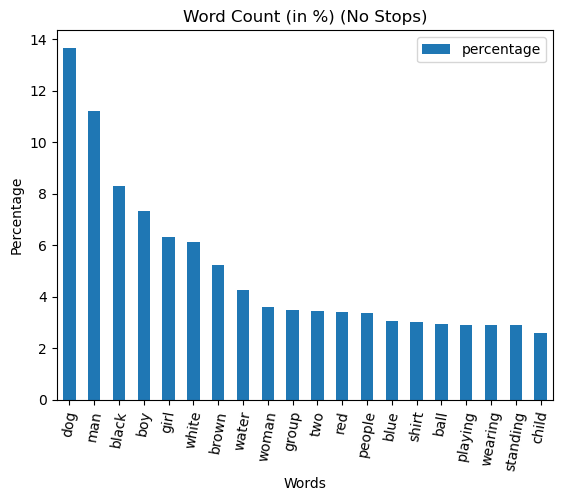

In [22]:
word_frequency = pd.DataFrame(data=tokenizernostop.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 20
word_frequency = word_frequency.sort_values("count", ascending=False).head(20)
# Total for %
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar", y="percentage", rot=0, title="Word Count (in %) (No Stops)")
plt.ylabel('Percentage')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

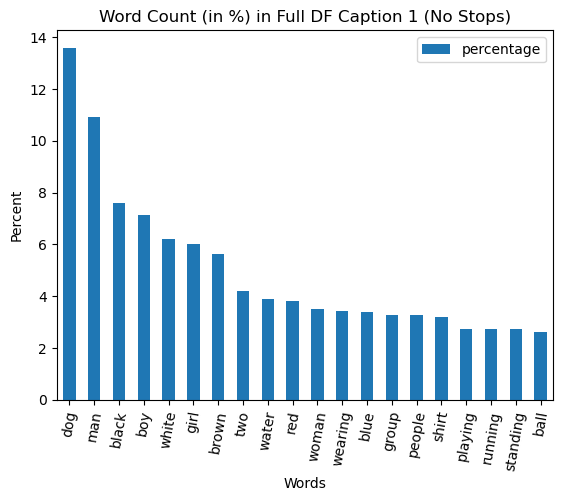

In [23]:
df1['cnostop'] = df1['caption1'].apply(remove_stop_words)
tokenizerfulldfnostop = Tokenizer()
tokenizerfulldfnostop.fit_on_texts(df1['cnostop'])
df1['tokenized_nostops'] = tokenizerfulldfnostop.texts_to_sequences(df1['cnostop'])
word_frequency = pd.DataFrame(data=tokenizerfulldfnostop.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 20
word_frequency = word_frequency.sort_values("count", ascending=False).head(20)
# Total for %
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar", y = 'percentage', rot=0, title="Word Count (in %) in Full DF Caption 1 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

We can see that the top 4 words are the same between my sample and the full caption 1 word count, and after those top words the others are largely within a couple spots of each other. I believe that this shows that the distribution of my sample is close enough to the full captions to get a representative account of the types of images present in the dataset.

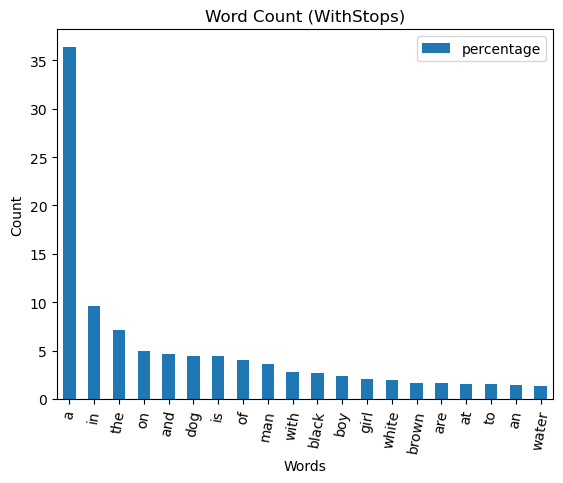

In [24]:
word_frequency = pd.DataFrame(data=tokenizer.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 20
word_frequency = word_frequency.sort_values("count", ascending=False).head(20)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar", y = 'percentage', rot=0, title="Word Count (WithStops)")
plt.ylabel('Count')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

As a matter of curiosity, I wanted to see the most frequent occurrences of words including stop counts. In my final model set, I omit words of lenght 1 like "a" because as shown here and confirmed through the modeling process, the word "a" was being overused in generated captions.

The following graphs are for ensuring that my choice in keeping only caption 1 was reasonable. To do this, I compared the top 5 word occurrences in caption 1 to the rest of the captions. This section is currently moot because my final models include information from all 5 captions.

In [25]:
df2 = pd.read_pickle('caption2.pkl')
df2.rename(columns={2:'caption2'},inplace=True)
df2['caption2nostop'] = df2['caption2'].apply(remove_stop_words)
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(df2['caption2nostop'])

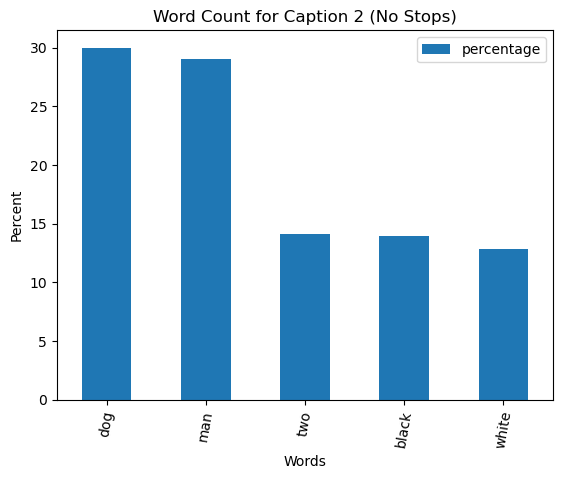

In [26]:
word_frequency = pd.DataFrame(data=tokenizer2.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 2 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

In [27]:
df3 = pd.read_pickle('caption3.pkl')
df3.rename(columns={3:'caption3'},inplace=True)
df3['caption3nostop'] = df3['caption3'].apply(remove_stop_words)
tokenizer3 = Tokenizer()
tokenizer3.fit_on_texts(df3['caption3nostop'])

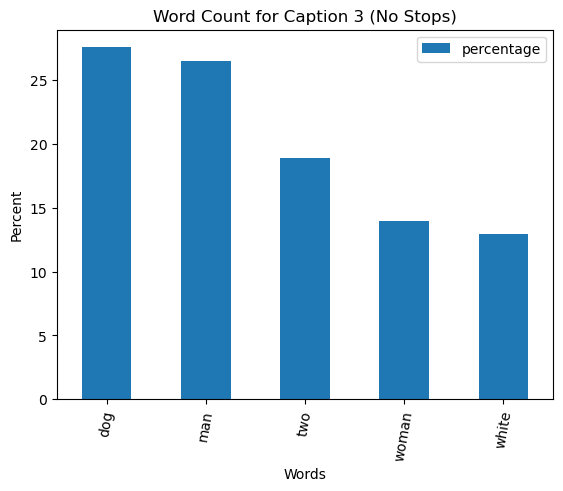

In [28]:
word_frequency = pd.DataFrame(data=tokenizer3.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 3 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

In [29]:
df4 = pd.read_pickle('caption4.pkl')
df4.rename(columns={4:'caption4'},inplace=True)
df4['caption4nostop'] = df4['caption4'].apply(remove_stop_words)
tokenizer4 = Tokenizer()
tokenizer4.fit_on_texts(df4['caption4nostop'])

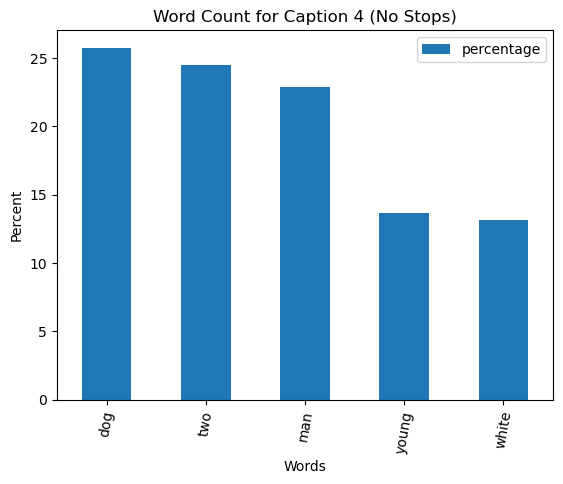

In [30]:
word_frequency = pd.DataFrame(data=tokenizer4.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 4 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

In [31]:
df5 = pd.read_pickle('caption5.pkl')
df5.rename(columns={5:'caption5'},inplace=True)
df5['caption5nostop'] = df5['caption5'].apply(remove_stop_words)
tokenizer5 = Tokenizer()
tokenizer5.fit_on_texts(df5['caption5nostop'])

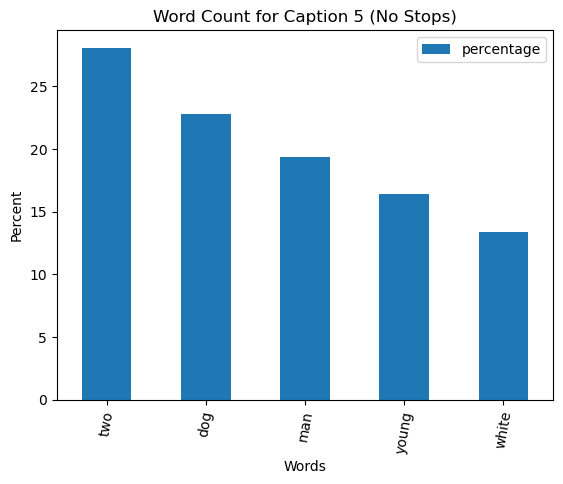

In [32]:
word_frequency = pd.DataFrame(data=tokenizer5.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 5 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

Given the similarities in top 5 words and their frequencies, choosing any single caption of the five would have been representative of the entire sample.

## <a id='toc1_4_'></a>[Tokenization and training split for Models 1 - 12](#toc0_)

Note that tokenization was performed before training split for captions of models 1 - 12. In order to be representative of the existence of completely new words during generation of caption, I will create the training split after tokenization. This captures the true maximum vocabulary present in the dataset.

In [22]:
#X is the image
#y is the tokenized caption. i will first try with stop words in because these captions are short
X = df1_sample['image']
y = df1_sample['tokenized']
y2 = df1_sample['tokenized_nostops']

In [34]:
y

6687    [3, 1, 181, 15, 7, 901, 17, 296, 48, 902, 400, 2]
6793    [3, 1, 484, 202, 4, 1, 28, 7, 13, 254, 8, 41, ...
7916               [3, 1, 9, 8, 41, 20, 105, 4, 5, 22, 2]
3742    [3, 1, 26, 10, 255, 42, 203, 12, 626, 627, 93,...
2122        [3, 1, 9, 12, 1, 161, 4, 47, 10, 1, 17, 9, 2]
                              ...                        
3606           [3, 1, 14, 69, 36, 5, 74, 199, 214, 28, 2]
5704         [3, 1, 11, 127, 1, 437, 1979, 52, 1, 177, 2]
6637    [3, 1, 11, 124, 25, 210, 52, 23, 35, 92, 20, 3...
2575    [3, 1, 762, 1980, 5, 1981, 10, 296, 8, 895, 4,...
7336       [3, 1, 17, 9, 158, 52, 20, 216, 21, 67, 78, 2]
Name: tokenized, Length: 1618, dtype: object

In [35]:
X_remain, X_test, y_remain, y_test = train_test_split(X, y, train_size=0.85, random_state=2)

In [23]:
X_remain, X_test, y_remainnostop, y_testnostop = train_test_split(X, y2, train_size=0.85, random_state=2)

In [36]:
X_remain.shape

(1375,)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, train_size=0.935, random_state=2)

In [24]:
X_train, X_val, y_trainnostop, y_valnostop = train_test_split(X_remain, y_remainnostop, train_size=0.935, random_state=2)

In [38]:
X_train.shape

(1285,)

In [39]:
X_val.shape

(90,)

Now that I have the images for each set, I will move these images into their own pre-created folders for future ease. Note that the files were moved in the initial models and when the split was recreated with all 5 captions, the images chosen for the train-test split didn't change though the tokenization order did.

In [40]:
for filename in X_test:
    source_path = os.path.join(imagefolder, filename)
    destination_path = os.path.join(testdirectory, filename)
    shutil.copyfile(source_path, destination_path)

for filename in X_train:
    source_path = os.path.join(imagefolder, filename)
    destination_path = os.path.join(traindirectory, filename)
    shutil.copyfile(source_path, destination_path)

for filename in X_val:
    source_path = os.path.join(imagefolder, filename)
    destination_path = os.path.join(valdirectory, filename)
    shutil.copyfile(source_path, destination_path)

In [ ]:
X_train.to_pickle('trainpics.pkl')
X_test.to_pickle('testpics.pkl')
X_val.to_pickle('valpics.pkl')

In [ ]:
y_val.to_pickle('valtokens.pkl')
y_train.to_pickle('traintokens.pkl')
y_test.to_pickle('testtokens.pkl')

In [25]:
y_valnostop.to_pickle('valtokens_nostop.pkl')
y_trainnostop.to_pickle('traintokens_nostop.pkl')
y_testnostop.to_pickle('testtokens_nostop.pkl')

## <a id='toc1_5_'></a>[Image Features for Models 9 - 17](#toc0_)

My models 5 - 8 were taking far too long to run so I decided to extract image features using the basemodel first and then use them as inputs. I was hoping that I would be able to simply use the basemodel as an input for the images since that would be ideal to process images that aren't specified to be in the train/val/test sets, so it would increase the final model's utility, but it is infeasible for my computer setup. In modeling for models 9 - 17, then, the extracted features are used to generate image arrays of their relevant features.

Features of Images

In [7]:
basemodel = EfficientNetV2S(
    weights='imagenet',
    include_preprocessing=True,
    include_top=False,
    input_shape=(224,224,3)
)
for layer in basemodel.layers:
    layer.trainable = False
basemodel.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [8]:
def extract_features(directory):
    """
    Function: Extract features from images using a pre-trained model.

    Parameters:
        directory (str): The path to the directory containing the images.

    Returns:
        dict: A dictionary mapping image filenames to their corresponding feature vectors.

    This function takes a directory containing images as input and extracts deep features from each image
    using a pre-trained model. It returns a dictionary containing the image filenames as keys and their
    corresponding feature vectors as values.

    The model used for feature extraction is assumed to be previously defined and stored in the 'basemodel'
    variable. The model should be compatible with the images in the directory and should output a fixed-size
    feature vector for each input image.

    The function iterates through each image in the directory, loads the image, and converts it to a numpy array.
    The image is then fed into the pre-trained model to obtain the deep features. The resulting feature vector
    is stored in the dictionary with the image filename as the key.

    Note:
    - The 'basemodel' variable should be a pre-trained deep learning model that can process images and output
      fixed-size feature vectors. Make sure to load or define this model before calling this function.
    - The image filenames in the 'directory' parameter should be unique, as the function uses the filenames as
      keys in the returned dictionary.
    """
    # load the model
    model = basemodel
    # extract features from each photo
    features = dict()
    for name in os.listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get features
        image = image.reshape((1, 224, 224, 3))
        feature = model.predict(image, verbose=0)
        # get image id
        #image_id = name.split('.')[0]
        # store feature
        features[name] = feature
        print('>%s' % name)
    return features

In [11]:
#extract features of train images
features = extract_features(traindirectory)
print('Extracted Features: %d' % len(features))
#save to file
dump(features, open('features.pkl', 'wb'))

>1022454332_6af2c1449a.jpg
>102351840_323e3de834.jpg
>1030985833_b0902ea560.jpg
>103106960_e8a41d64f8.jpg
>1032460886_4a598ed535.jpg
>104136873_5b5d41be75.jpg
>1056338697_4f7d7ce270.jpg
>106514190_bae200f463.jpg
>1067180831_a59dc64344.jpg
>1072153132_53d2bb1b60.jpg
>1075716537_62105738b4.jpg
>107582366_d86f2d3347.jpg
>109202756_b97fcdc62c.jpg
>109260218_fca831f933.jpg
>1093716555_801aacef79.jpg
>109823395_6fb423a90f.jpg
>1105959054_9c3a738096.jpg
>110595925_f3395c8bd6.jpg
>1110208841_5bb6806afe.jpg
>1115565519_d976d4b1f1.jpg
>1131800850_89c7ffd477.jpg
>1142847777_2a0c1c2551.jpg
>1143373711_2e90b7b799.jpg
>1143882946_1898d2eeb9.jpg
>115684808_cb01227802.jpg
>1164765687_7aca07bbe7.jpg
>1193116658_c0161c35b5.jpg
>1197800988_7fb0ca4888.jpg
>1215334959_b1970965f7.jpg
>121800200_bef08fae5f.jpg
>1224851143_33bcdd299c.jpg
>1234817607_924893f6e1.jpg
>1235580648_7eebaed9bc.jpg
>1235681222_819231767a.jpg
>123889082_d3751e0350.jpg
>1245022983_fb329886dd.jpg
>1248357227_2b4175fc39.jpg
>1248734482_3

In [12]:
#extract features of validation images
valfeatures = extract_features(valdirectory)
print('Extracted Features: %d' % len(valfeatures))
dump(valfeatures, open('valfeatures.pkl','wb'))

>1148238960_f8cacec2fc.jpg
>1263801010_5c74bf1715.jpg
>1432179046_8e3d75cf81.jpg
>1446933195_8fe9725d62.jpg
>150582765_bad8dec237.jpg
>1597319381_1e80d9e39c.jpg
>2054308369_f9c6ec7815.jpg
>2056930414_d2b0f1395a.jpg
>2098418613_85a0c9afea.jpg
>2170187328_65c2f11891.jpg
>2193223202_4d908c0450.jpg
>2196050115_e236d91f52.jpg
>2206600240_f65df56a09.jpg
>2252264255_03fefc25af.jpg
>2363006088_b3e3aa5c0b.jpg
>241345446_2e47ae8ddc.jpg
>247637795_fdf26a03cf.jpg
>2519594430_551225e5bd.jpg
>2528552898_9e49a7033f.jpg
>2555535057_007501dae5.jpg
>2602258549_7401a3cdae.jpg
>2609900643_c07bcb0bae.jpg
>2612608861_92beaa3d0b.jpg
>2623146491_b64698b875.jpg
>2715035273_8fc8b1291c.jpg
>2730994020_64ac1d18be.jpg
>2738255684_0324ed062d.jpg
>2747436384_9470c56cb9.jpg
>2838085973_42b6e9b5b1.jpg
>2853811730_fbb8ab0878.jpg
>2868136205_3cf679208d.jpg
>287999021_998c2eeb91.jpg
>2891924845_92f69b0f18.jpg
>2911919938_6bb6587a36.jpg
>2929006980_9f9f8f3d21.jpg
>2934379210_4e399e3cac.jpg
>300148649_72f7f0399c.jpg
>30053

In [13]:
#extract features of test images
testfeatures = extract_features(testdirectory)
print('Extracted Features: %d' % len(testfeatures))
dump(testfeatures, open('testfeatures.pkl','wb'))

>1000268201_693b08cb0e.jpg
>1001773457_577c3a7d70.jpg
>101654506_8eb26cfb60.jpg
>1089755335_0bfbfd30e6.jpg
>1115679311_245eff2f4b.jpg
>1160441615_fe6b3c5277.jpg
>118309463_a532b75be9.jpg
>1187435567_18173c148b.jpg
>1211015912_9f3ee3a995.jpg
>1232148178_4f45cc3284.jpg
>1289142574_2bd6a082dd.jpg
>1332208215_fa824f6659.jpg
>1348304997_afe60a61df.jpg
>1363843090_9425d93064.jpg
>1386964743_9e80d96b05.jpg
>1415591512_a84644750c.jpg
>145721496_687af9bb18.jpg
>152029243_b3582c36fa.jpg
>166654939_80ea4ddbcc.jpg
>1685990174_09c4fb7df8.jpg
>1778020185_1d44c04dae.jpg
>1799271536_6e69c8f1dc.jpg
>1802092493_7b44fdb6b9.jpg
>1980315248_82dbc34676.jpg
>2003663004_5b70920a98.jpg
>2049051050_20359a434a.jpg
>2064417101_3b9d817f4a.jpg
>2114739371_83aa8bdb0e.jpg
>2149968397_a7411729d1.jpg
>2169951750_495820a215.jpg
>2171891283_dedd9cf416.jpg
>2208055895_37cd8e1edf.jpg
>2229509318_be3fef006b.jpg
>2264316030_600e55748d.jpg
>2265096094_8cc34d669c.jpg
>2267682214_e1434d853b.jpg
>2271671533_7538ccd556.jpg
>22724

## <a id='toc1_6_'></a>[Processing all 5 captions for Models 13 - 17](#toc0_)

In order to process all 5 captions per image for late stage modeling, I first went back to the EDA file to ensure that the captions_by_path.pkl was available. Then I read it in here and begin the preprocessing.

In [27]:
all5df = pd.read_pickle('captions_by_path.pkl')
all5df

caption_order,image,1,2,3,4,5
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...
...,...,...,...,...,...,...
8086,990890291_afc72be141.jpg,A man does a wheelie on his bicycle on the sid...,A man is doing a wheelie on a mountain bike .,A man on a bicycle is on only the back wheel .,Asian man in orange hat is popping a wheelie o...,Man on a bicycle riding on only one wheel .
8087,99171998_7cc800ceef.jpg,A group is sitting around a snowy crevasse .,A group of people sit atop a snowy mountain .,A group of people sit in the snow overlooking ...,Five children getting ready to sled .,Five people are sitting together in the snow .
8088,99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...,A large bird stands in the water on the beach .,A tall bird is standing on the sand beside the...,A water bird standing at the ocean 's edge .,A white crane stands tall as it looks out upon...
8089,997338199_7343367d7f.jpg,A person stands near golden walls .,a woman behind a scrolled wall is writing,A woman standing near a decorated wall writes .,The walls are covered in gold and patterns .,"Woman writing on a pad in room with gold , dec..."


In [28]:
#having numbers as column names is inconvenient for calling these columns
all5df.rename(columns={1:'caption1', 2:'caption2', 3:'caption3', 4:'caption4', 5:'caption5'},inplace=True)

In [29]:
all5df.head()

caption_order,image,caption1,caption2,caption3,caption4,caption5
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,A girl going into a wooden building .,A little girl climbing into a wooden playhouse .,A little girl climbing the stairs to her playh...,A little girl in a pink dress going into a woo...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,A black dog and a tri-colored dog playing with...,A black dog and a white dog with brown spots a...,Two dogs of different breeds looking at each o...,Two dogs on pavement moving toward each other .
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...,A little girl is sitting in front of a large p...,A small girl in the grass plays with fingerpai...,There is a girl with pigtails sitting in front...,Young girl with pigtails painting outside in t...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .,A man lays on the bench to which a white dog i...,a man sleeping on a bench outside with a white...,A shirtless man lies on a park bench with his ...,man laying on bench holding leash of dog sitti...
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .,A man wears an orange hat and glasses .,A man with gauges and glasses is wearing a Bli...,A man with glasses is wearing a beer can croch...,The man with pierced ears is wearing glasses a...


I was extra concerned about whether my abacus computer could handle all 5 captions (since it would increase the length of data generated through the generator, would increase the validation array size, and would likely increase modeling time), so I still sampled my images down by the same degree as I had in the single caption case. The dataframe was sample down using the same random_state as the single caption dataframe. This ensured that the images were the same as the ones already moved into the folders.

In [36]:
all5_sample, _, _, _ = train_test_split(all5df, all5df, train_size=0.2, random_state=2)

In [37]:
#removing punctuation, capitalization, leading and ending spaces, taking out single letter words, and appending 'start' and 'end' for modeling
captcols = all5_sample[['caption1','caption2','caption3','caption4','caption5']]
for i in captcols:
    all5_sample[i] = all5_sample[i].apply(lambda text: text.lower())
    all5_sample[i] = all5_sample[i].apply(lambda text: re.sub(r'[^\w\s]', '', text))
    all5_sample[i] = all5_sample[i].apply(lambda text: text.strip())
    all5_sample[i] = all5_sample[i].apply(lambda text: ' '.join([word for word in text.split() if len(word) > 1])) #taking out 'a'
    all5_sample[i] = 'start ' + all5_sample[i] + ' end'

In [38]:
all5_sample.head()

caption_order,image,caption1,caption2,caption3,caption4,caption5
6687,3644142276_caed26029e.jpg,start blond girl and brunette brown hanging by...,start kids practicing karate with harnesses to...,start people dangling from straps kicking at e...,start two children kick each other while being...,start two children play while being suspended ...
6793,3670907052_c827593564.jpg,start bmx rider in red and black outfit is jum...,start dirt biker flies through the air end,start guy in red on bike in midair end,start man in red outfit jumps his motocross bi...,start someone in red on bike is moving in mida...
7916,774009278_8e75b7d498.jpg,start dog is jumping to play in the water end,start white dog is jumping up at jet of water end,start white dog jumping in green grass by bric...,start white dog jumps from the grass into wate...,start white dog jumps on the green grass next ...
3742,3027399066_ca85495775.jpg,start group of greyhound dogs racing with muzz...,start group of greyhounds racing with jerseys ...,start group of racing dogs wearing striped uni...,start four greyhound dogs are racing against e...,start racing dogs wearing jerseys with numbers...
2122,2511019188_ca71775f2d.jpg,start dog with frisbee in front of brown dog end,start large black dog is catching frisbee whil...,start two dark colored dogs romp in the grass ...,start two dogs are catching blue frisbees in g...,start two dogs are playing one is catching fri...


I already know that I'll need the max length of a single caption, so I'll find the max length of captions by column and take the largest number of that as the max length. I will simply store this as a variable in the modeling file.

In [67]:
#initialize a dictionary to store the maximum sentence length for each column
max_lengths = {}

#iterate through each column in the DataFrame
for column in all5_sample.columns:
    #find the maximum sentence length for the current column
    max_length = all5_sample[column].apply(lambda sentence: len(sentence.split())).max()
    max_lengths[column] = max_length

print(max_lengths)

{'image': 1, 'caption1': 29, 'caption2': 25, 'caption3': 29, 'caption4': 26, 'caption5': 28, 'merged_captions': 97}


I note that the max lengths have all decreased from the previous single caption version since I'm taking the max length without "a" in the sentences. These max lengths also include 'start' and 'end' tokens, but I suspect that is fine because otherwise, we would have to cut off the longest sentences during padding (since start and end tokens would add two additional words unaccounted for in the max_length) It is also good to note that the max lengths across captions are relatively consistent.

In [90]:
#having the merged captions all in one column as a big blob will be helpful for tokenizer fitting
all5_sample['merged_captions_blob'] = all5_sample.apply(lambda row: ' '.join(row[['caption1', 'caption2', 'caption3', 'caption4', 'caption5']]), axis=1)

In [91]:
#having the captions in a list all in a single column will be helpful for tokenizer text to sequence generation in the modeling stage
all5_sample['merged_captions'] = all5_sample.apply(lambda row: row[['caption1', 'caption2', 'caption3', 'caption4', 'caption5']].tolist(), axis=1)

In [92]:
#sanity check
all5_sample['merged_captions'][0]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

Given the larger vocabulary sizes with all 5 captions, I split my data into train test split before tokenizer fitting so that there is no data leakage. This process is the same as I had performed in the single caption scenario

In [93]:
X5 = all5_sample['image']
y5 = all5_sample[['merged_captions', 'merged_captions_blob', 'caption1']]

In [94]:
X5_remain, X5_test, y5_remain, y5_test = train_test_split(X5, y5, train_size=0.85, random_state=2)

In [95]:
y5_test.drop(columns=['merged_captions', 'merged_captions_blob'], inplace=True)

In [96]:
y5_remain.drop(columns='caption1', inplace=True)

In [97]:
X5_train, X5_val, y5_train, y5_val = train_test_split(X5_remain, y5_remain, train_size=0.935, random_state=2)

In [98]:
X5_train

3803    3042484940_0975a5e486.jpg
3912     307321761_606fc91673.jpg
4410    3187395715_f2940c2b72.jpg
4124    3123351642_3794f2f601.jpg
5320    3372022051_132b8e6233.jpg
                  ...            
6585    3626642428_3396568c3c.jpg
548     1499581619_a5f65a882c.jpg
1363     226531363_33ac01d931.jpg
4131    3124964754_2e8a98fb09.jpg
2494    2635164923_2a774f7854.jpg
Name: image, Length: 1285, dtype: object

In [99]:
X5_train.to_pickle('trainpics5.pkl')
X5_test.to_pickle('testpics5.pkl')
X5_val.to_pickle('valpics5.pkl')
y5_train.to_pickle('traintokens5.pkl')
y5_test.to_pickle('testtokens5.pkl')
y5_val.to_pickle('valtokens5.pkl')

In [100]:
X5df = pd.DataFrame(X5_train)
y5df = pd.DataFrame(y5_train)
train5_df = pd.concat([X5df, y5df], axis=1)
train5_df

,image,merged_captions,merged_captions_blob
3803,3042484940_0975a5e486.jpg,[start man holds up an electronic device while...,start man holds up an electronic device while ...
3912,307321761_606fc91673.jpg,[start group of children in uniforms stand out...,start group of children in uniforms stand outs...
4410,3187395715_f2940c2b72.jpg,[start boy on skateboard is making jump from b...,start boy on skateboard is making jump from bl...
4124,3123351642_3794f2f601.jpg,[start snowboarder in bright green performing ...,start snowboarder in bright green performing j...
5320,3372022051_132b8e6233.jpg,[start boy is airborne on bicycle above an urb...,start boy is airborne on bicycle above an urba...
...,...,...,...
6585,3626642428_3396568c3c.jpg,"[start group of dogs standing in river end, st...",start group of dogs standing in river end star...
548,1499581619_a5f65a882c.jpg,[start couple dressed in hoodies kissing on th...,start couple dressed in hoodies kissing on the...
1363,226531363_33ac01d931.jpg,"[start dog runs across the snowy field end, st...",start dog runs across the snowy field end star...
4131,3124964754_2e8a98fb09.jpg,[start man jumping barrel while skateboarding ...,start man jumping barrel while skateboarding e...


In [101]:
train5_df.to_pickle('train5df.pkl')

In [102]:
X5vdf = pd.DataFrame(X5_val)
y5vdf = pd.DataFrame(y5_val)
val5_df = pd.concat([X5vdf, y5vdf], axis=1)
val5_df

,image,merged_captions,merged_captions_blob
1178,2193223202_4d908c0450.jpg,[start boy takes football from another boy end...,start boy takes football from another boy end ...
5228,3353328134_dd9ed0edab.jpg,"[start skier doing flip in wooded area end, st...",start skier doing flip in wooded area end star...
7839,689776124_07f560a920.jpg,[start black dog is happily running through th...,start black dog is happily running through the...
2456,2623146491_b64698b875.jpg,[start man in black is purchasing something at...,start man in black is purchasing something at ...
138,1148238960_f8cacec2fc.jpg,[start bicyclists are standing at an intersect...,start bicyclists are standing at an intersecti...
...,...,...,...
2028,247637795_fdf26a03cf.jpg,"[start man and woman at the waterfront end, st...",start man and woman at the waterfront end star...
1222,2206600240_f65df56a09.jpg,[start elderly lady and middleaged man talk ov...,start elderly lady and middleaged man talk ove...
4007,3096918227_f9d26a7db2.jpg,[start skateboarder is performing grab trick w...,start skateboarder is performing grab trick wh...
474,1446933195_8fe9725d62.jpg,"[start black puppy is biting tree limb end, st...",start black puppy is biting tree limb end star...


In [103]:
val5_df.drop(columns='merged_captions_blob', inplace=True)

In [104]:
val5_df.to_pickle('val5df.pkl')

In the test set, I will keep only caption 1 and the image file. I need to preserve one caption as a reference for BLEU score evaluation against the generated caption. There is no principled reason for me to keep caption 1 as all of the captions have roughly the same word distributions. Since BLEU is only one method of evaluation and a human reader will ultimately serve as the best evaluation for a generated caption, I have simply picked caption 1 for ease of comparison.

In [105]:
#for testing, I only need a caption to compare the generated caption to
X5testdf = pd.DataFrame(X5_test)
y5testdf = pd.DataFrame(y5_test)
test5_df = pd.concat([X5testdf, y5testdf], axis=1)
test5_df

,image,caption1
6919,3697379772_40d831392b.jpg,start man playing white guitar and singing as ...
6167,3540416981_4e74f08cbb.jpg,start dog chases stuffed animal attached to st...
6276,3561537309_e271d57492.jpg,start boy in blue shorts standing in the surf end
7202,413737417_b0a8b445e9.jpg,start group camps in desolate area end
1652,2370221025_be4d9a4431.jpg,start man wearing green jacket is holding onto...
...,...,...
1673,237953705_cfe6999307.jpg,start group of young children playing in the g...
2338,2584957647_4f9235c150.jpg,start dog is wading through deep water while h...
5306,3368569524_a9df2fc312.jpg,start girl defends the basketball from another...
4491,3207676216_48478bce97.jpg,start man being pulled behind sled led by nume...


In [106]:
test5_df.to_pickle('test5df.pkl')

## <a id='toc1_7_'></a>[Moving Forward](#toc0_)

There were multiple different preprocessing strategies within the lifespan of this project. I tried the following methods:
- Single captions tokenized before training split
- 5 captions tokenized after training split (tokenizer fit to the training set)
- Images arrayed
- Image features extracted via EfficientNet2VS

In the next notebook, I proceed to modeling. As seen from this notebook, there were many iterations and changes throughout the modeling process. Those changes will be documented in the modeling notebook while the final output will be saved in a "final" notebook.